<a href="https://colab.research.google.com/github/bman222112/ECE551/blob/main/Module%207_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="font-size:28px;font-weight:bold;">Module 7 - Residual Neural Networks</p>
This module introduces the concept of Residual Neural Networks, and how to handle processing the feature extracted audio dataset.</br></br>
The first thing, below, is a class, <span style="color:green;font-weight:bold;">class</span> <span style="color:blue;font-weight:bold">CCDataset</span>, this is almost identical to the one used in Module 6. We will pass in a different transform to enable compatibility with our pretrained ResNet model. The one difference is that the first line of <span style="color:blue;font-weight:bold">__getitem__</span> repeats the 2D dataset 3 times across the last axis, producing the type of 3-Channel data that the ResNet18 model expects

In [1]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs

Detected operating system as Ubuntu/jammy.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.4.14
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Need to get 8,917 kB of archives.
After this operation, 8,712 kB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu jammy/main amd64 git-lfs amd64 3.7.0 [8,917 kB]
Fetched 8,917 kB in 0s (28.8 MB/s)
debconf: unable to initialize frontend: Dialog
debco

In [2]:
%cd /content
!git clone https://www.github.com/bman222112/ECE551.git
%cd /content/ECE551

/content
Cloning into 'ECE551'...
remote: Enumerating objects: 1033, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1033 (delta 8), reused 3 (delta 1), pack-reused 1009 (from 2)
Receiving objects: 100% (1033/1033), 750.48 MiB | 33.58 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Updating files: 100% (949/949), done.
Filtering content: 100% (2/2), 252.93 MiB | 75.25 MiB/s, done.
/content/ECE551


In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [4]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import torch

class CCDataset(Dataset):
    def __init__(self, labels, datafile, inds, transform=None, target_transform=None):
        self.labels = np.load(labels).astype("int");
        self.data = np.load(datafile).astype(np.float32);
        self.transform = transform
        self.target_transform = target_transform
        self.indices = inds;

    def __len__(self):
        return len(self.indices);

    def __getitem__(self, idx):
        dat = np.repeat(self.data[self.indices[idx],:,:,np.newaxis],3,axis=2);
        if self.transform:
            dat = self.transform(dat);
        if self.target_transform:
            dat = self.target_transform(dat);
        return dat, self.labels[self.indices[idx]];

Because we don't know how many total samples there are yet, to generate the random indicies, we can read in the labels definition and use it's length to generate the ranges

In [5]:
labels = np.load("Labels_aug.npy");

In [6]:
import random
random.seed(10)
trainInds = random.sample(range(len(labels)),round(len(labels)*0.9));
testInds = [item for item in random.sample(range(len(labels)),round(len(labels))) if item not in trainInds];


With the ranges for training and test specified, we can read in the data using our <span style="color:blue;font-weight:bold;">CCDataset</span> class. Notice we are only reading in the MFCC and LFCC data. Because the LPC dataset is not 2-Dimensional, the ResNet model is not compatible. We also establish the transformation necessary to match the expected 224x224 format for ResNet18

In [7]:
from torchvision import transforms
ToResnet = transforms.Compose([transforms.ToTensor(),transforms.Resize((224,224)),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),]);
MFCC_train_data = CCDataset("Labels_aug.npy","3D_MFCC_aug.npy",trainInds, transform=ToResnet);
MFCC_test_data = CCDataset("Labels_aug.npy","3D_MFCC_aug.npy",testInds, transform=ToResnet);
LFCC_train_data = CCDataset("Labels_aug.npy","3D_LFCC_aug.npy",trainInds, transform=ToResnet);
LFCC_test_data = CCDataset("Labels_aug.npy","3D_LFCC_aug.npy",testInds, transform=ToResnet);

Now that we have read in our data, we need a DataLoader object to use with training. Based on empirical testing, a batch size of 12 appeared to work well for this dataset. Increasing the batch size will dramatically reduce model training times, but may negatively impact performance.

In [8]:
from torch.utils.data import DataLoader
batch_size = 12

# Create data loaders.
MFCC_train_dataloader = DataLoader(MFCC_train_data, batch_size=batch_size)
MFCC_test_dataloader = DataLoader(MFCC_test_data, batch_size=batch_size)
LFCC_train_dataloader = DataLoader(LFCC_train_data, batch_size=batch_size)
LFCC_test_dataloader = DataLoader(LFCC_test_data, batch_size=batch_size)

for X, y in MFCC_train_dataloader:
    print(f"Shape of X [N, C, M, T]: {X.shape} {X.dtype}")
    print("N = batch size. This is the number of images to process at a time.")
    print("C = number of channels. Only 1 for Cepstrum Coefficient Data")
    print("M = number of Cepstrum Coefficients")
    print("T = time in blocks")
    print(" ")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print("y is of size N, the ground truth labels")
    print(y)
    break

train_size = len(MFCC_train_dataloader.dataset)
test_size  = len(MFCC_test_dataloader.dataset)
train_pct  = 100*train_size/(train_size+test_size)
test_pct   = 100*test_size/(train_size+test_size)
print(f"Percentage of training dataset = {train_pct:.2f} percent with {train_size} samples.")
print(f"Percentage of test dataset     = {test_pct:.2f} percent with {test_size} samples.")

Shape of X [N, C, M, T]: torch.Size([12, 3, 224, 224]) torch.float32
N = batch size. This is the number of images to process at a time.
C = number of channels. Only 1 for Cepstrum Coefficient Data
M = number of Cepstrum Coefficients
T = time in blocks
 
Shape of y: torch.Size([12]) torch.int64
y is of size N, the ground truth labels
tensor([10,  1,  8,  7, 10,  1,  5,  7,  6,  6, 11,  3])
Percentage of training dataset = 90.01 percent with 2479 samples.
Percentage of test dataset     = 9.99 percent with 275 samples.


As can be seen, the resulting output for the MFCC_train_dataloader shows an output for training of <b>[batch, 3, MFCCs, Time]</b>, matching our MFCC data and the batch size, along with the 3 channel modification necessary for the ResNet.</br></br>
Next, we'll define our class names, along with a quick test to see what the first item out of our dataset is, and verify it is labeled correctly

In [9]:
classes = ["Pump 1 Start", "Pump 1 Run", "Pump 1 Stop", "Pump 2 Start", "Pump 2 Run", "Pump 2 Stop", "Pump 3 Start", "Pump 3 Run", "Pump 3 Stop", "Pump 4 Start", "Pump 4 Run", "Pump 4 Stop"];

In [10]:
print(f"Expected: \t{classes[labels[trainInds[1]].astype('int')]}\nFrom Dataset: \t{classes[MFCC_train_data.__getitem__(1)[1]]}");

Expected: 	Pump 1 Run
From Dataset: 	Pump 1 Run


<p>Next, let's plot the data from the last batch determined from the dataloader above. This will show what the data looks like, and verify the labels for the samples in the batch</p>

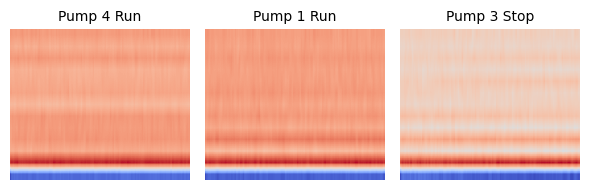

In [11]:
import matplotlib.pyplot as plt
import math
def show_images(batch_tensor, n=3, titles=None):
    """
    Display all Cepstrum Coefficients from a batch [B, 1, H, W]

    Parameters:
    - batch_tensor: torch.Tensor of shape [B, 1, H, W]
    - n: number of plots to show
    - titles: list of titles or labels for each image (length n)
    """
    n = min(n, batch_tensor.size(0))
    if titles is None:
        titles = [f"Image {i}" for i in range(n)]
    else:
        assert len(titles) >= n, "Not enough titles for the number of images."

    # Determine grid size
    cols = n
    rows = 1;

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(n):
        img = batch_tensor[i, 0].cpu().numpy()
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='coolwarm', aspect="auto", interpolation="none")
        plt.gca().invert_yaxis();
        plt.title(classes[y[i]], fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(batch_tensor=X, n=3, titles=y)

<p>Next, we are ready for our ResNet Model. This model is largely used as is. The one necessary change is to modify the fc layer for our 12 class output.</p>

In [12]:
import torchvision.models as mods
from torch import nn

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
torch.cuda.empty_cache()
model = mods.resnet18(weights=mods.ResNet18_Weights.IMAGENET1K_V1);
model.fc = nn.Linear(model.fc.in_features, 12);
model = model.to(device);


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.2MB/s]


<p>Looking at the full model, we can print the model and the full list of parameters for each layer</p>

In [13]:
def parameter_report(model):
    print(f"{'Layer':<40} {'# Params':>12} {'Trainable':>10}")
    print("-" * 65)
    total, trainable = 0, 0
    for name, param in model.named_parameters():
        num_params = param.numel()
        is_trainable = param.requires_grad
        print(f"{name:<40} {num_params:>12,} {str(is_trainable):>10}")
        total += num_params
        if is_trainable:
            trainable += num_params
    print("-" * 65)
    print(f"{'Total':<40} {total:>12,} {'':>10}")
    print(f"{'Trainable':<40} {trainable:>12,}")


print(model)
print(" ")

parameter_report(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<p>As seen above, this model is substantially more complex than the CNN models used in Module 6.</p>
<p>To train the model, we need to specify a loss function and an optimizer. In order to keep things similar to our testing in Module 6, this will remain unchanged.</p>

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

<p>The training function, defined below, runs through a given number of epochs, or until the model demonstrates small enough changes to the average training loss. For each epoch, the function runs through all of the batches within the dataloader and tests the model accuracy. After each epoch, a learning rate scheduler is update, with the goal of tailoring the learning rate to the current optimization state. Both an Exponential learning rate and a MultiStep learning rate scheduler are used to try and improve the speed at which the average loss converges.</p>

<p>In addition, a progress bar is printed to monitor training progress. If interested in the progression of the training, there is a commented print statement that will produce the average loss rate for each epoch</p>

In [16]:
from torch.optim.lr_scheduler import LRScheduler
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import ExponentialLR

def train(dataloader, model, loss_fn, optimizer, epochs):
    size = len(dataloader.dataset)
    model.train() # Put the model in training mode.
    scheduler1 = ExponentialLR(optimizer, gamma=0.9)
    scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    print(f"  0%[{20*' '}]\r",end="");
    loss_last = 0;
    twice = False;
    for ep in range(epochs):
        test_loss, num = 0, 0
        for batch, (X, y) in enumerate(dataloader):
            # Place the model and predictions on the same device.
            X, y = X.to(device), y.to(device)
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item();
            num+=1;

            # Backpropagation
            # This step updates the parameter values inside your network.
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            del X, y, pred;
            torch.cuda.empty_cache()
        if (loss_last - (test_loss/num)  < 0.005 and loss_last - (test_loss/num) > 0):
            if twice:
                break;
            else:
                twice = True;
        else:
            loss_last = test_loss/num;

        #print(f"loss: {test_loss/num:>7f}")
        print(f"{100*(ep/epochs):3.0f}%[{int(20 * ep/epochs)*'■'}{(20-int(20 * ep/epochs))*' '}]\r",end="");   # Print a progress bar. A number of blocks are printed based on the percentage through the count of epochs
        # Step the learning rate schedulers based on the current status
        scheduler1.step();
        scheduler2.step();
    print(f"100%[{20*'■'}]\r");        # We need to make sure to jump the progress bar to 100% at the end, especially if we broke early due to small enough change in loss

<p>To test the model, we have the following function, which will calculate the accuracy of the model on another (the test) dataloader</p>

In [17]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Put the model in testing mode.
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss;

<p>Finally it is time to train the model. The following two functions will run through the training, and then print the accuracy and average loss for the test dataset. Due to the complexity of this network, training is not fast. Keeping to a smaller number of Epochs is necessary, but the model does train with similar success in that reduced number of epochs</p>

<p>It has been observed through testing that when using CUDA, occasionally the model training will fail and loss will remain in excess of 2. If this happens, generally, running all cells again should fix the issue.</p>

In [18]:
train(MFCC_train_dataloader, model, loss_fn, optimizer, 20);
acc, loss = test(MFCC_test_dataloader, model, loss_fn)
print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")

100%[■■■■■■■■■■■■■■■■■■■■]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.378263 



In [19]:
acc, loss = test(MFCC_train_dataloader,model,loss_fn)
print(f"Train Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")

Train Error: 
 Accuracy: 96.2%, Avg loss: 0.239999 



<p>We can save the model weights to use later if desired.</p>

In [20]:
torch.save(model.state_dict(), "Res_Net_MFCC.pth")

<p>We can also quickly grab a random test index and plot it to see if the predicted and actual labels match</p>

Outputs for all categories:
tensor([[-0.1571, -2.7960,  0.1030,  1.0761, -1.4104,  0.9061,  7.1509,  0.1523,
         -0.8372, -0.1789,  0.2076, -1.1313]], device='cuda:0')
Predicted: "Pump 3 Start", Actual: "Pump 3 Start"


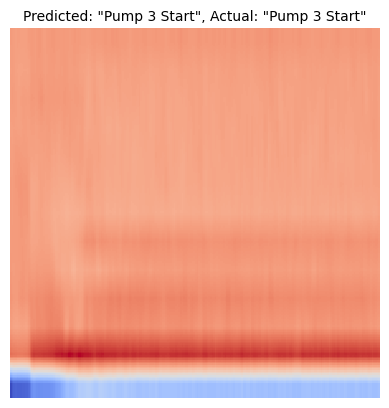

In [21]:
# Put the model in evaluation mode.
model.eval()

# Grab a test index
test_index = 105
x, y = MFCC_test_data[test_index][0], MFCC_test_data[test_index][1]

img  = x.squeeze()[0]

with torch.no_grad():
    x = x.to(device)

    pred = model(x.unsqueeze(0)) # Create a batch size = 1 using unsqueeze()

    print("Outputs for all categories:")
    print(pred)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

    plt.imshow(img, cmap='coolwarm', interpolation="none")
    plt.gca().invert_yaxis();
    plt.title(f'Predicted: "{predicted}", Actual: "{actual}"', fontsize=10)
    plt.axis('off')
    plt.show()

<p>Finally, we can generate ROC curves and AUC scores for each of the One-vs-Rest cases</p>

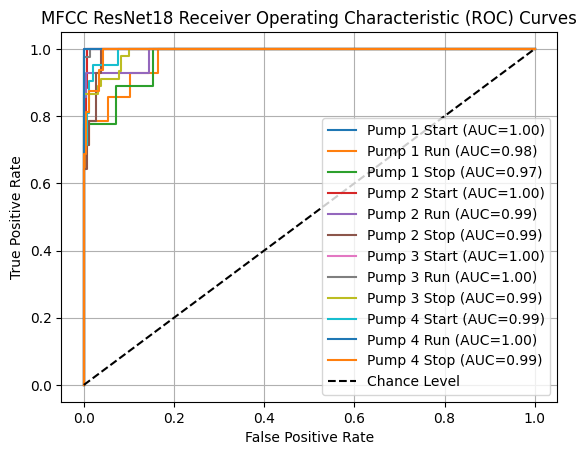

In [22]:
from torchmetrics.classification import ROC
from torchmetrics.classification import AUROC
import matplotlib.pyplot as plt

model.eval()
pred = 0;
for i in range(len(testInds)):
    # Grab a test index
    x, y_inst = MFCC_test_data[i]
    with torch.no_grad():
        x = x.to(device)
        if type(pred)==int:
            pred = model(x.unsqueeze(0))
            y = y_inst;
        else:
            pred = torch.cat((pred,model(x.unsqueeze(0))),dim=0);
            y = np.append(y, y_inst);
y = torch.as_tensor(y).to(device);

roc_metric = ROC(task="multiclass", num_classes=12)
roc_metric.update(pred, y)
fpr, tpr, thresholds = roc_metric.compute()

AUC = AUROC(task="multiclass", num_classes=12, average=None)
AUC.update(pred, y)
AUCs = AUC.compute()
#print(f"Aggregate ROC AUC: {AUCs[0].cpu().numpy():.4f}")


plt.figure()
for i in range(12):
    plt.plot(fpr[i].cpu(), tpr[i].cpu(), label=f"{classes[i]} (AUC={AUCs[i].cpu().numpy():.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level") # dashed diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MFCC ResNet18 Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.grid()
plt.show()